This was for neural net modeling of our original problem statement (predicting response time). It is no longer needed.

In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input


In [2]:
# load in data (this uses the clean EMS data merged with weather data):
results_df = pd.read_csv('data/ems_weather.csv').drop(columns=['Unnamed: 0'])
features = results_df.columns

In [3]:
# What is the time range?
results_df['CALL_YEAR'].min(), results_df['CALL_YEAR'].max()

(2005, 2021)

In [4]:
#check for NULLS:

columns = results_df.columns
d = []
for col in columns:
    nulls = results_df[col].isna().sum()
    d.append({'column': col, 'NULLS': nulls})
chk = pd.DataFrame(d)
chk[chk['NULLS']>0]

,column,NULLS
847,AWND,831


SELECT COLUMNS 

In [5]:
y = np.array(results_df['INCIDENT_RESPONSE_SECONDS_QY'])

# definitely drop these:
drop_features = ['INCIDENT_RESPONSE_SECONDS_QY', 
                 'CAD_INCIDENT_ID', 
                 'FIRST_ASSIGNMENT_DATETIME', 
                 'INCIDENT_TRAVEL_TM_SECONDS_QY']
# suggest dropping these, because we have so much redundant location information: 
drop_features += list(features[230:594]) # zip codes
drop_features += list(features[670:831]) # city council district, community district, community school dist, congressional district

drop_features += ['AWND'] # because it has too many NULL values.

# transform into np.array for neural net modeling:
X = np.array(results_df.drop(columns=drop_features))



FIRST NEURAL NET MODEL, ALL FEATURES

In [6]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

# Scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)


In [7]:
X_train.shape

(15019, 324)

In [8]:
# Estimate how many nodes to use, as a first cut:
np.power(15019/325,.5)

6.797963495952865

In [16]:
#set random state for reproducability:
np.random.seed(42)

model = Sequential()

# Input:
model.add(Input(shape=X_train_sc.shape[1]))

# 3 hidden layers, 32, 16, 8 nodes (decreasing in sequence)
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))

# Output
model.add(Dense(1, activation=None))

# compile
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# fit
results = model.fit(X_train_sc, y_train, epochs=100, batch_size=256, validation_data=(X_test_sc, y_test))



Epoch 1/100
59/59 [==============================] - 1s 9ms/step - loss: 523041.2083 - mae: 527.3245 - val_loss: 515032.7812 - val_mae: 527.4952
Epoch 2/100
59/59 [==============================] - 0s 8ms/step - loss: 567078.7203 - mae: 528.1364 - val_loss: 496481.9688 - val_mae: 511.9111
Epoch 3/100
59/59 [==============================] - 0s 6ms/step - loss: 454963.5797 - mae: 488.6115 - val_loss: 389961.5312 - val_mae: 416.7817
Epoch 4/100
59/59 [==============================] - 0s 5ms/step - loss: 303063.8667 - mae: 365.4428 - val_loss: 218779.7656 - val_mae: 258.3721
Epoch 5/100
59/59 [==============================] - 0s 5ms/step - loss: 296006.7807 - mae: 251.9269 - val_loss: 178890.3281 - val_mae: 239.0426
Epoch 6/100
59/59 [==============================] - 0s 6ms/step - loss: 182100.7318 - mae: 232.2896 - val_loss: 164278.5000 - val_mae: 233.2751
Epoch 7/100
59/59 [==============================] - 0s 6ms/step - loss: 145307.6574 - mae: 222.4557 - val_loss: 153499.3594 - val

ASSESS MODEL PERFORMANCE

In [17]:
# compare predictions to actual response time:
preds_all = model.predict(X_test_sc)

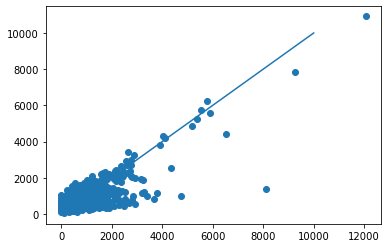

In [18]:
plt.scatter(y_test,preds_all);
plt.plot([0,10000],[0,10000]);

In [19]:
from sklearn.metrics import r2_score, mean_squared_error


In [20]:
r2_score(y_test,preds_all)

0.5620342694002103

In [21]:
mean_squared_error(y_test,preds_all,squared=False)

322.1236909372698

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                10400     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 11,073
Trainable params: 11,073
Non-trainable params: 0
_________________________________________________________________


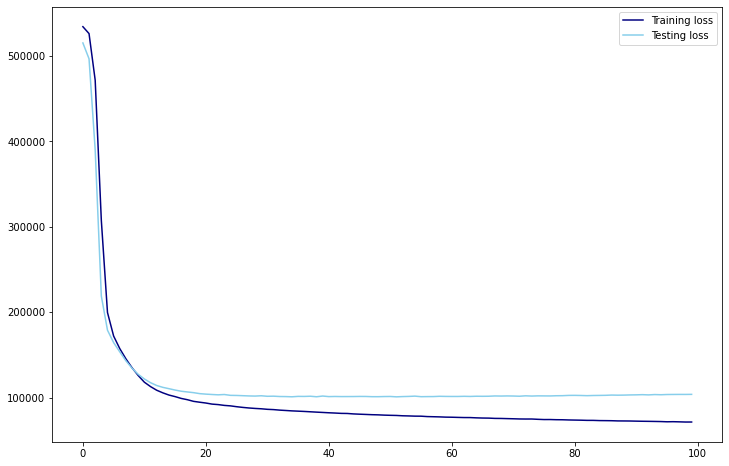

In [23]:
train_loss = results.history['loss']
test_loss = results.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

REDUCE FEATURE SET TO THE FEATURES THAT SURVIVED LASSO REGULARIZATION ON THE LINEAR REGRESSION MODEL

LOAD IN FEATURES, TRIM ARRAY

In [24]:
coefs_df = pd.read_csv('./data/lasso_coefs_no-travel-time.csv')
coefs_df

,Unnamed: 0,features,coefficients
0,0,INITIAL_SEVERITY_LEVEL_CODE,35.901861
1,1,FINAL_SEVERITY_LEVEL_CODE,4.469111
2,2,VALID_DISPATCH_RSPNS_TIME_INDC,0.000000
3,3,DISPATCH_RESPONSE_SECONDS_QY,5.702355
4,4,FIRST_ACTIVATION_DATETIME,319.166665
...,...,...,...
319,319,SNOW,4.841491
320,320,SNWD,5.007628
321,321,TMAX,0.000000
322,322,TMIN,0.000000


In [25]:
features = coefs_df[coefs_df['coefficients']!=0]['features']
features

0       INITIAL_SEVERITY_LEVEL_CODE
1         FINAL_SEVERITY_LEVEL_CODE
3      DISPATCH_RESPONSE_SECONDS_QY
4         FIRST_ACTIVATION_DATETIME
6           INCIDENT_CLOSE_DATETIME
                   ...             
314                  CALL_MONTH_NOV
316                  CALL_MONTH_SEP
318                            PRCP
319                            SNOW
320                            SNWD
Name: features, Length: 179, dtype: object

In [26]:
X = np.array(results_df[features])


BUILD THE SAME MODEL, BUT ON THIS REDUCED FEATURE SPACE

In [27]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

# Scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)


In [28]:
len(features)

179

In [29]:
model179 = Sequential()
model179.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model179.add(Dense(16, activation='relu'))
model179.add(Dense(8, activation='relu'))
model179.add(Dense(1, activation=None))

model179.compile(loss='mse', optimizer='adam', metrics=['mae'])

results179 = model179.fit(X_train_sc, y_train, epochs=100, batch_size=256, validation_data=(X_test_sc, y_test))



Epoch 1/100
59/59 [==============================] - 2s 14ms/step - loss: 489049.1641 - mae: 519.6951 - val_loss: 512800.4688 - val_mae: 525.6812
Epoch 2/100
59/59 [==============================] - 1s 10ms/step - loss: 454230.9016 - mae: 515.2686 - val_loss: 485705.9375 - val_mae: 503.2910
Epoch 3/100
59/59 [==============================] - 0s 6ms/step - loss: 450580.4188 - mae: 479.1013 - val_loss: 368148.7188 - val_mae: 399.1358
Epoch 4/100
59/59 [==============================] - 0s 7ms/step - loss: 367737.8117 - mae: 350.2055 - val_loss: 204689.2344 - val_mae: 253.6147
Epoch 5/100
59/59 [==============================] - 0s 5ms/step - loss: 214074.1073 - mae: 244.4740 - val_loss: 165015.1875 - val_mae: 236.9019
Epoch 6/100
59/59 [==============================] - 0s 7ms/step - loss: 173633.7107 - mae: 230.8404 - val_loss: 149395.0000 - val_mae: 227.6701
Epoch 7/100
59/59 [==============================] - 1s 10ms/step - loss: 147901.9789 - mae: 223.3629 - val_loss: 138278.4844 - 

ASSESS MODEL PERFORMANCE

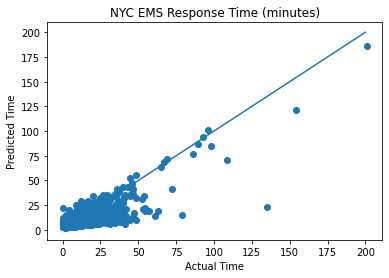

In [30]:
preds179 = model179.predict(X_test_sc)
plt.scatter(y_test/60,preds179/60);
plt.plot([0,200],[0,200]);
plt.title('NYC EMS Response Time (minutes)');
plt.xlabel('Actual Time');
plt.ylabel('Predicted Time');


In [33]:
r2_score(y_test,preds179), mean_squared_error(y_test,preds179,squared=False)

(0.5781691370984812, 316.1344156841037)

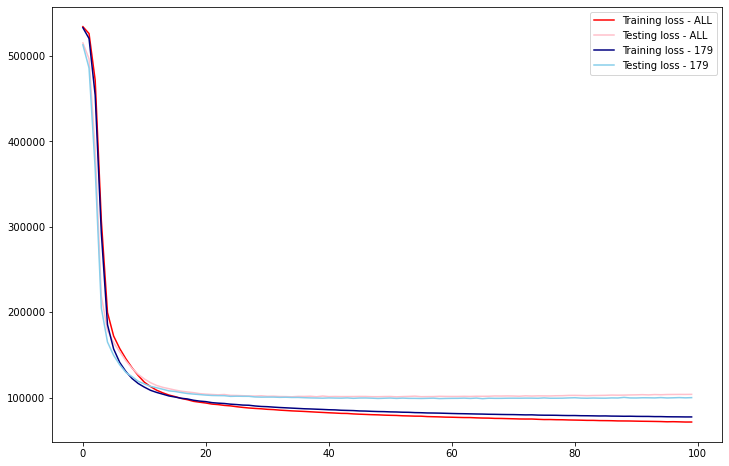

In [34]:
train_loss = results.history['loss']
test_loss = results.history['val_loss']
train_loss_179 = results179.history['loss']
test_loss_179 = results179.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss - ALL', color='red')
plt.plot(test_loss, label='Testing loss - ALL', color='pink')
plt.plot(train_loss_179, label='Training loss - 179', color='navy')
plt.plot(test_loss_179, label='Testing loss - 179', color='skyblue')
plt.legend();

WHAT ARE THESE FEATURES?

In [35]:
for feature in features:
    print(feature)

INITIAL_SEVERITY_LEVEL_CODE
FINAL_SEVERITY_LEVEL_CODE
DISPATCH_RESPONSE_SECONDS_QY
FIRST_ACTIVATION_DATETIME
INCIDENT_CLOSE_DATETIME
HELD_INDICATOR
REOPEN_INDICATOR
SPECIAL_EVENT_INDICATOR
INITIAL_CALL_TYPE_ABDPN
INITIAL_CALL_TYPE_AMPMIN
INITIAL_CALL_TYPE_ARREST
INITIAL_CALL_TYPE_ASTHMB
INITIAL_CALL_TYPE_CARD
INITIAL_CALL_TYPE_CARDBR
INITIAL_CALL_TYPE_CARDFC
INITIAL_CALL_TYPE_CHOKE
INITIAL_CALL_TYPE_CVA
INITIAL_CALL_TYPE_CVAC
INITIAL_CALL_TYPE_DIFFBR
INITIAL_CALL_TYPE_DROWN
INITIAL_CALL_TYPE_EDP
INITIAL_CALL_TYPE_EDPC
INITIAL_CALL_TYPE_ELECT
INITIAL_CALL_TYPE_FIRE75
INITIAL_CALL_TYPE_HEAT
INITIAL_CALL_TYPE_INBLFC
INITIAL_CALL_TYPE_INJALS
INITIAL_CALL_TYPE_INJMAJ
INITIAL_CALL_TYPE_INJURY
INITIAL_CALL_TYPE_JUMPUP
INITIAL_CALL_TYPE_MEDRXN
INITIAL_CALL_TYPE_OBMAJ
INITIAL_CALL_TYPE_OBMIS
INITIAL_CALL_TYPE_OBOUT
INITIAL_CALL_TYPE_OTHER
INITIAL_CALL_TYPE_PD13
INITIAL_CALL_TYPE_PD13C
INITIAL_CALL_TYPE_PEDSTR
INITIAL_CALL_TYPE_RAPE
INITIAL_CALL_TYPE_RESPIR
INITIAL_CALL_TYPE_SEIZR
INITIAL_CALL_T

NEURAL NET REGULARIZATION

In [36]:
# Import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [37]:

model_reg = Sequential()
model_reg.add(Dense(32, input_dim=X_train_sc.shape[1], 
                    activation='relu',
                    kernel_regularizer=l2(.01)))
#model_reg.add(Dropout(0.2))
model_reg.add(Dense(16,  
                    activation='relu',
                    kernel_regularizer=l2(.01)))
#model_reg.add(Dropout(0.2))
model_reg.add(Dense(8,  
                    activation='relu',
                    kernel_regularizer=l2(.01)))
#model_reg.add(Dropout(0.2))
model_reg.add(Dense(1, activation=None))

model_reg.compile(loss='mse', optimizer='adam', metrics=['mae'])

early_stop = EarlyStopping(patience=5)

results_reg = model_reg.fit(X_train_sc, y_train, epochs=100, batch_size=256, \
                            validation_data=(X_test_sc, y_test), callbacks=[early_stop])



Epoch 1/100
59/59 [==============================] - 1s 9ms/step - loss: 609472.4359 - mae: 528.5408 - val_loss: 517091.3750 - val_mae: 529.3272
Epoch 2/100
59/59 [==============================] - 0s 6ms/step - loss: 544687.1589 - mae: 526.3383 - val_loss: 513922.0625 - val_mae: 526.6427
Epoch 3/100
59/59 [==============================] - 0s 4ms/step - loss: 508799.3203 - mae: 519.7875 - val_loss: 498766.0312 - val_mae: 514.6532
Epoch 4/100
59/59 [==============================] - 0s 5ms/step - loss: 469091.7026 - mae: 501.5970 - val_loss: 436864.6250 - val_mae: 465.2807
Epoch 5/100
59/59 [==============================] - 0s 5ms/step - loss: 403432.9609 - mae: 436.6043 - val_loss: 301745.9688 - val_mae: 343.7538
Epoch 6/100
59/59 [==============================] - 0s 4ms/step - loss: 307877.3430 - mae: 313.5037 - val_loss: 200355.6562 - val_mae: 264.3596
Epoch 7/100
59/59 [==============================] - 0s 5ms/step - loss: 209113.7654 - mae: 255.1777 - val_loss: 167891.0781 - val

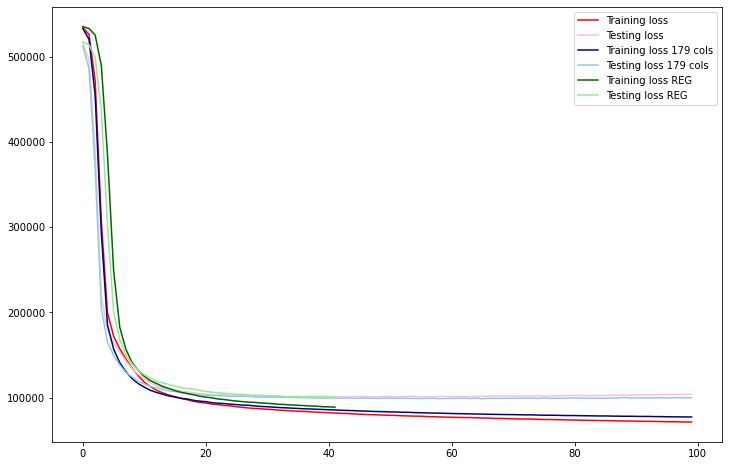

In [38]:
train_loss = results.history['loss']
test_loss = results.history['val_loss']
train_loss_179 = results179.history['loss']
test_loss_179 = results179.history['val_loss']
train_loss_reg = results_reg.history['loss']
test_loss_reg = results_reg.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='red')
plt.plot(test_loss, label='Testing loss', color='pink')
plt.plot(train_loss_179, label='Training loss 179 cols', color='navy')
plt.plot(test_loss_179, label='Testing loss 179 cols', color='skyblue')
plt.plot(train_loss_reg, label='Training loss REG', color='darkgreen')
plt.plot(test_loss_reg, label='Testing loss REG', color='lightgreen')
plt.legend();



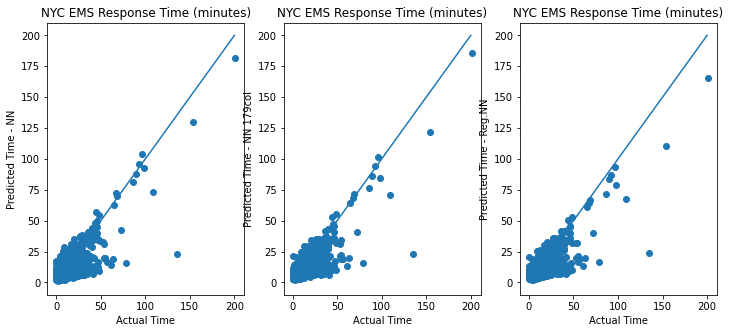

In [39]:
fig = plt.figure(figsize=(12,5));

ax = fig.add_subplot(131);
plt.scatter(y_test/60,preds_all/60);
plt.plot([0,200],[0,200]);
plt.title('NYC EMS Response Time (minutes)');
plt.xlabel('Actual Time');
plt.ylabel('Predicted Time - NN');

ax = fig.add_subplot(132);
plt.scatter(y_test/60,preds179/60);
plt.plot([0,200],[0,200]);
plt.title('NYC EMS Response Time (minutes)');
plt.xlabel('Actual Time');
plt.ylabel('Predicted Time - NN 179col');

ax = fig.add_subplot(133);
preds_reg = model_reg.predict(X_test_sc)
plt.scatter(y_test/60,preds_reg/60);
plt.plot([0,200],[0,200]);
plt.title('NYC EMS Response Time (minutes)');
plt.xlabel('Actual Time');
plt.ylabel('Predicted Time - Reg.NN');


In [40]:
print(f'Neural Net, all features, no reg. R2={r2_score(y_test,preds_all)}, RMS={mean_squared_error(y_test,preds_all,squared=False)}')
print(f'Neural Net, all features, no reg. R2={r2_score(y_test,preds179)}, RMS={mean_squared_error(y_test,preds179,squared=False)}')
print(f'Neural Net, all features, no reg. R2={r2_score(y_test,preds_reg)}, RMS={mean_squared_error(y_test,preds_reg,squared=False)}')


Neural Net, all features, no reg. R2=0.5620342694002103, RMS=322.1236909372698
Neural Net, all features, no reg. R2=0.5781691370984812, RMS=316.1344156841037
Neural Net, all features, no reg. R2=0.5755005987058774, RMS=317.13278600842233


This does not appear to be very practical.

In [42]:
print(f'Our best RMS is about {np.round(317.132786/60,4)} minutes.')

Our best RMS is about 5.2855 minutes.


In [47]:
print(f'The average response time is {np.round(y_test.mean()/60,4)} min, with a std dev of {np.round(y_test.std()/60,4)} min.')

The average response time is 8.8287 min, with a std dev of 8.1124 min.


In [55]:
pred_null = [y_train.mean() for y in y_test]
rms_null = mean_squared_error(y_test,pred_null,squared=False)

print(f'For comparison, the null hypothesis has an RMS of {np.round(rms_null/60,4)} min.')
print(f'And the R2 score was {r2_score(y_test,pred_null)}. (Basically 0% of the variance, not surprisingly.)')

For comparison, the null hypothesis has an RMS of 8.1126 min.
And the R2 score was -4.696005082460708e-05. (Basically 0% of the variance, not surprisingly.)


So, this is an improvement over the NULL, but we would like to be able to do better.